# Credit Card Fraud Detection

# Objective
The primary goal of this analysis is to develop a predictive model to accurately detect fraudulent credit card transactions. Given the high cost and risk associated with fraud, this model aims to:

- Minimize financial loss: By identifying potential frauds early, credit card companies can reduce losses and prevent unauthorized charges.
- Enhance customer protection: Detecting fraudulent transactions in real time can protect customers from being charged for purchases they did not make.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve

# Dataset
This analysis utilizes the Credit Card Fraud Detection dataset from Kaggle (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data), which comprises credit card transactions made by European cardholders in September 2013.

In [2]:
# Load the dataset (ensure the CSV file is in your working directory)
df = pd.read_csv("data/creditcard.csv")

<b>Features<b>
- Time: Represents the seconds elapsed between each transaction and the first transaction in the dataset.
- PCA-transformed variables (V1 to V28): These features result from a Principal Component Analysis (PCA) to protect confidentiality.
- Amount: The transaction amount.

<b>Target<b>
- Class: A binary indicator where 1 represents a fraudulent transaction and 0 a legitimate one.

In [3]:
# Display basic information about the dataset
print("Dataset Information:")
print(df.info())

print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  fl

# Exploratory Data Analysis

/var/folders/ly/w484tkcx5c7c7ybl9rgjy09r000fsz/T/ipykernel_1506/3773742218.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette=['blue', 'red'], ax=axes[2])


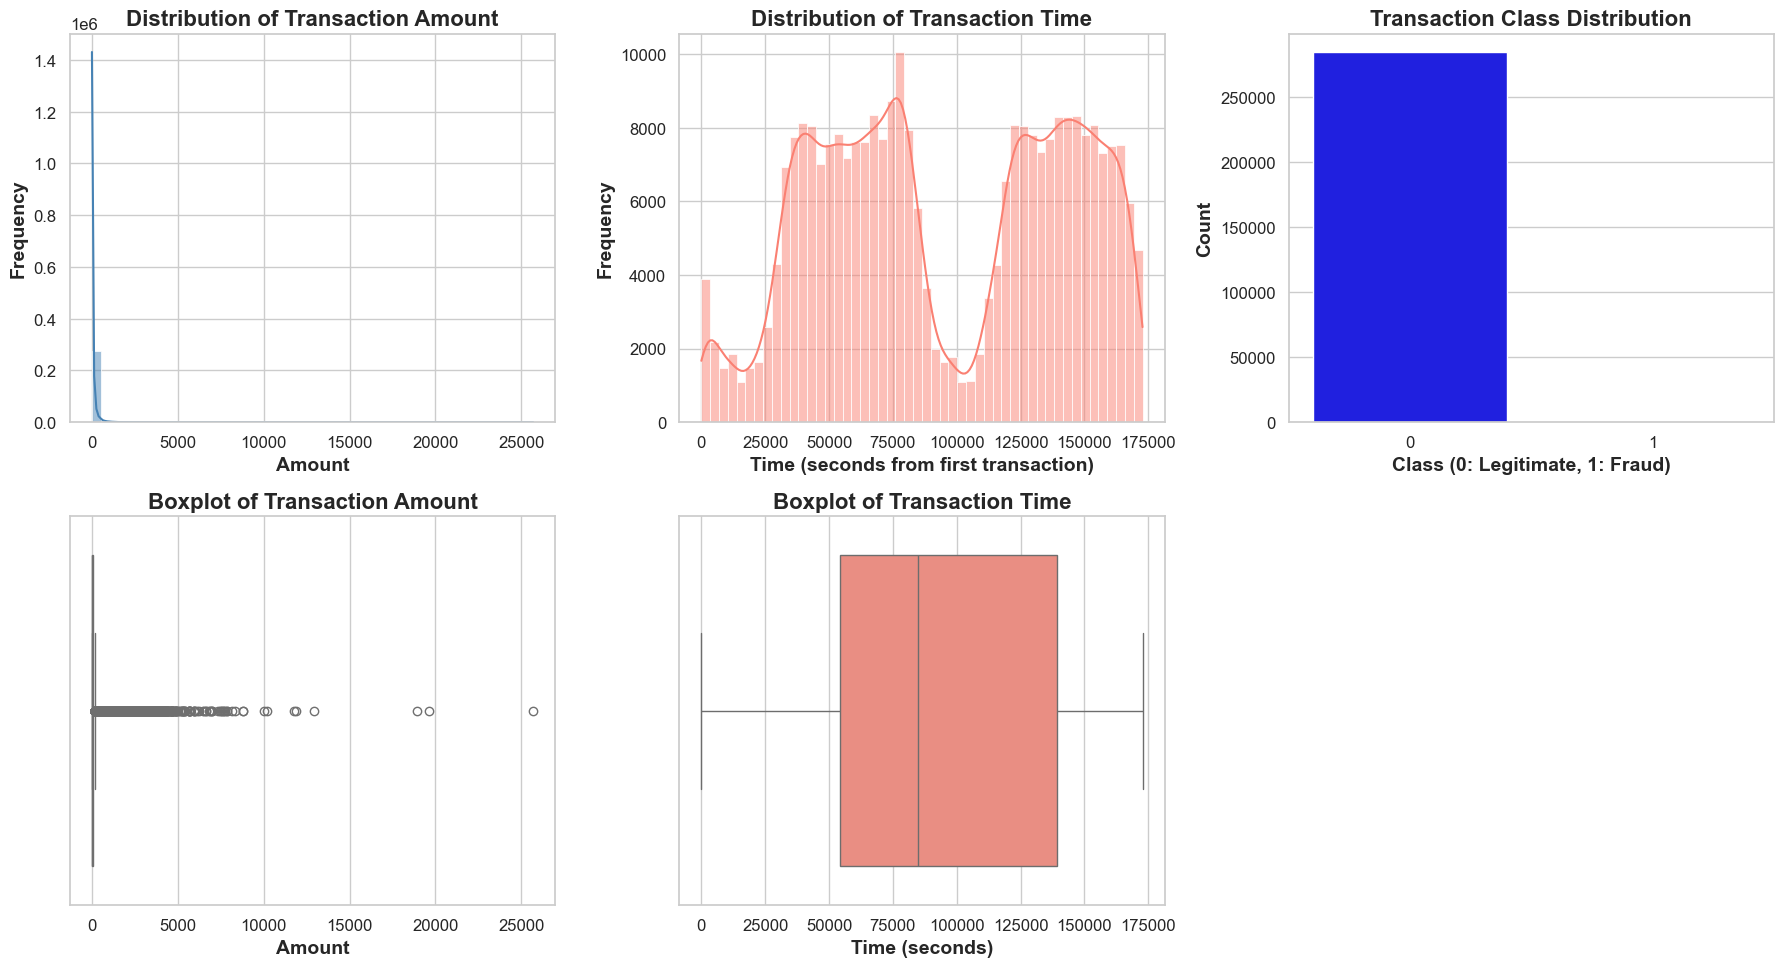

In [4]:
# Set a consistent style and customize rcParams for a polished look
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titleweight"] = "bold"

# Create a grid layout: 2 rows x 3 columns (we have 5 plots, so one subplot will be removed)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot 1: Distribution of 'Amount'
sns.histplot(df['Amount'], bins=50, kde=True, color='steelblue', ax=axes[0])
axes[0].set_title("Distribution of Transaction Amount")
axes[0].set_xlabel("Amount")
axes[0].set_ylabel("Frequency")

# Plot 2: Distribution of 'Time'
sns.histplot(df['Time'], bins=50, kde=True, color='salmon', ax=axes[1])
axes[1].set_title("Distribution of Transaction Time")
axes[1].set_xlabel("Time (seconds from first transaction)")
axes[1].set_ylabel("Frequency")

# Plot 3: Class Distribution (Legitimate vs. Fraudulent)
sns.countplot(x='Class', data=df, palette=['blue', 'red'], ax=axes[2])
axes[2].set_title("Transaction Class Distribution")
axes[2].set_xlabel("Class (0: Legitimate, 1: Fraud)")
axes[2].set_ylabel("Count")

# Plot 4: Boxplot of 'Amount'
sns.boxplot(x=df['Amount'], color='skyblue', ax=axes[3])
axes[3].set_title("Boxplot of Transaction Amount")
axes[3].set_xlabel("Amount")

# Plot 5: Boxplot of 'Time'
sns.boxplot(x=df['Time'], color='salmon', ax=axes[4])
axes[4].set_title("Boxplot of Transaction Time")
axes[4].set_xlabel("Time (seconds)")

# Remove the unused subplot (if any)
if len(axes) > 5:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

- Heavily skewed data: The ‘Amount’ variable shows a right-skewed distribution with many small transactions and a few high-value outliers.
- Time insights: The 'Time' variable, representing the elapsed seconds from the first transaction, spans a wide range, with certain peaks that may reflect typical business hours or higher activity periods.
- Extreme class imbalance: The Class distribution plot shows high imbalance, with fraud cases making up only 0.173% of the data. This imbalance requires special consideration during model training and evaluation.

In [5]:
print('Non-Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,3), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,3), '% of the dataset')

Non-Frauds 99.827 % of the dataset
Frauds 0.173 % of the dataset


# Data Preprocessing

- Missing values: No missing values detected in the dataset.
- Outliers: The boxplot for 'Amount' confirms the presence of extreme values. These outliers are expected given the nature of transaction data.

- Scaling: The 'Amount' and 'Time' features need to scaled to bring them in line with the PCA-transformed variables.
- Class imbalance: There are several sampling techniques to address class imbalance (undersampling, oversampling, SMOTE). In this case, we use undersampling, which consists of removing data in order to have a balanced dataset and thus avoiding our models to overfitting. We apply undersampling within the classifier pipeline to prevent data leakage into the test data, which can happen if undersampling is done before splitting the dataset (for cross-validation and evaluation on test data).

<b> Scaling

In [6]:
# Scale the 'Amount' and 'Time' (since PCA features are already scaled)
rob_scaler = RobustScaler()
df['Amount_scaled'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time_scaled'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Display the first few rows to verify new features
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V23       V24       V25       V26       V27  \
0  0.098698  0.363787  ... -0.110474  0.066928  0.128539 -0.189115  0.133558   
1  0.085102 -0.255425  ...  0.101288 -0.339846  0.167170  0.125895 -0.008983   
2  0.247676 -1.514654  ...  0.909412 -0.689281 -0.327642 -0.139097 -0.055353   
3  0.377436 -1.387024  ... -0.190321 -1.175575  0.647376 -0.221929  0.062723   
4 -0.270533  0.817739  ... -0.137458  0.141267 -0.206010  0.502292  0.219422   

        V28  Amount  Class  Amou

# Modeling

We explore three different models to determine which classifier is most effective for detecting fraudulent transactions. Each model brings its own set of strengths and potential trade-offs:

<b>Logistic Regression<b>

- Interpretability: The coefficients of the logistic regression model provide direct insights into how each feature affects the likelihood of fraud. This transparency makes it easier to understand which features drive the model's decisions.
- Regularization: Techniques like L1 (lasso) and L2 (ridge) regularization can be applied to prevent overfitting, especially important when dealing with high-dimensional data common in fraud detection scenarios.
- Limitations: Although effective for linearly separable data, logistic regression may struggle if the true relationship between features and fraud is non-linear.

<b>Support Vector Machine (SVM)<b>

- Flexibility: SVMs can handle non-linear relationships by employing different kernel functions (e.g., linear, RBF). The kernel trick allows the model to map input features into higher-dimensional spaces, which can uncover complex patterns in the data.
- Robustness to outliers: With proper parameter tuning, SVMs can be robust against outliers, a beneficial trait for fraud detection where data anomalies may be present.
- Limitations: SVMs can be computationally intensive, particularly with large datasets. As such, careful selection of kernel type and tuning of hyperparameters (like C and gamma) is essential to balance performance and resource usage.

<b>Decision Tree<b>

- Interpretability: Decision trees naturally highlight which features are most important through their hierarchical structure. This can be critical in fraud detection to understand which factors are most predictive of fraudulent behavior.
- Ease of visualization: They provide a visual representation that is easy to interpret, making it straightforward to communicate how decisions are made.
- Limitations: Decision trees can easily overfit if not properly pruned. Ensemble techniques (like Random Forest or Gradient Boosting) are often used in tandem to improve generalization while maintaining interpretability.

<b>Evaluation<b>

The model evaluation focuses on performance metrics such as the Area Under the Precision-Recall Curve (AUPRC), also known as Average Precision (AP), which are more informative than simple accuracy in contexts with imbalanced classes. These metrics provide a better understanding of how well the model distinguishes between the rare fraudulent cases and the abundant legitimate transactions. In fraud detection, recall is particularly critical since it emphasizes correctly identifying as many fraud instances as possible, even if this approach may lead to an increased number of false positives, thereby reducing the risk of overlooking potentially costly fraudulent activities.

In [7]:
# Prepare features and label
X = df.drop(columns=['Class', 'Amount', 'Time']) # This leaves the PCA features (V1...V28) plus the newly scaled features
y = df['Class']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
# Logistic Regression

# Create an imbalanced-learn pipeline with undersampling and logistic regression
log_reg_pipeline = ImbalancedPipeline(steps=[
    ('undersampler', RandomUnderSampler(random_state=42)), 
    # Using 'liblinear' solver to support both l1 and l2 penalties
    ('classifier', LogisticRegression(solver='liblinear', max_iter=1000))
])

# Set up hyperparameter grid for Logistic Regression
log_reg_param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Set up cross-validation strategy, using stratified folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Setup GridSearchCV, optimizing for average precision
log_reg_grid = GridSearchCV(estimator=log_reg_pipeline,
                    param_grid=log_reg_param_grid,
                    scoring='average_precision',  # Optimizes AUPRC
                    cv=cv,
                    n_jobs=-1,
                    verbose=1)

# Fit the grid search on the training data
log_reg_grid.fit(X_train, y_train)

# Display the best parameters and CV score from grid search
print("\nBest Params for Logistic Regression:", log_reg_grid.best_params_)
print("Best Average Precision (CV) for Logistic Regression:", log_reg_grid.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits

Best Params for Logistic Regression: {'classifier__C': 0.001, 'classifier__penalty': 'l2'}
Best Average Precision (CV) for Logistic Regression: 0.7448141885199254


In [9]:
# Evaluate on the test set
y_pred_log_reg = log_reg_grid.predict(X_test)
test_avg_precision_log_reg = average_precision_score(y_test, log_reg_grid.decision_function(X_test))
print("\nTest Set Average Precision:", test_avg_precision_log_reg)
print("\nClassification Report:\n", classification_report(y_test, y_pred_log_reg))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_log_reg))


Test Set Average Precision: 0.7121453063630072

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92     56864
           1       0.01      0.96      0.02        98

    accuracy                           0.86     56962
   macro avg       0.51      0.91      0.47     56962
weighted avg       1.00      0.86      0.92     56962


Confusion Matrix:
 [[48631  8233]
 [    4    94]]


In [10]:
# SVM

# Create an imbalanced-learn pipeline with undersampling and SVM
svm_pipeline = ImbalancedPipeline([
    ('undersampler', RandomUnderSampler(random_state=42)), 
    ('classifier', SVC(probability=True)) # probability=True to allow probability estimates if needed
])

# Set up the hyperparameter grid for SVM
svm_param_grid = [
    {'classifier__kernel': ['linear'],
     'classifier__C': [0.1, 1, 10, 100, 1000]},
    {'classifier__kernel': ['rbf'],
     'classifier__C': [0.1, 1, 10, 100, 1000],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10]}
]

# Set up cross-validation strategy, using stratified folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Setup GridSearchCV, optimizing for average precision
svm_grid = GridSearchCV(estimator=svm_pipeline,
                        param_grid=svm_param_grid,
                        scoring='average_precision',
                        cv=cv,
                        n_jobs=-1,
                        verbose=1)

# Fit grid search on the training data
svm_grid.fit(X_train, y_train)

# Display the best parameters and CV score from grid search
print("\nBest Params for SVM:", svm_grid.best_params_)
print("Best Average Precision (CV) for SVM:", svm_grid.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Params for SVM: {'classifier__C': 100, 'classifier__kernel': 'linear'}
Best Average Precision (CV) for SVM: 0.7434197678034068


In [11]:
# Evaluate on the test set
y_pred_svm = svm_grid.predict(X_test)
test_avg_precision_svm = average_precision_score(y_test, svm_grid.decision_function(X_test))
print("\nTest Set Average Precision for SVM:", test_avg_precision_svm)
print("\nClassification Report for SVM:\n", classification_report(y_test, y_pred_svm))
print("\nConfusion Matrix for SVM:\n", confusion_matrix(y_test, y_pred_svm))


Test Set Average Precision for SVM: 0.7159103024348119

Classification Report for SVM:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.03      0.92      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.52     56962
weighted avg       1.00      0.96      0.98     56962


Confusion Matrix for SVM:
 [[54362  2502]
 [    8    90]]


In [12]:
# Decission Tree

# Create an imbalanced-learn pipeline with undersampling and a Decission Tree
tree_pipeline = ImbalancedPipeline([
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Set up the hyperparameter grid for the Decision Tree
tree_param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [2, 3, 4, 5, 10],
    'classifier__min_samples_split': [2, 3, 4, 5, 10]
}

# Set up cross-validation strategy, using stratified folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Setup GridSearchCV, optimizing for average precision
tree_grid = GridSearchCV(estimator=tree_pipeline,
                        param_grid=tree_param_grid,
                        scoring='average_precision',
                        cv=cv,
                        n_jobs=-1,
                        verbose=1)

# Fit grid search on the training data
tree_grid.fit(X_train, y_train)

# Display the best parameters and CV score from grid search
print("\nBest Params for Decission Tree:", tree_grid.best_params_)
print("Best Average Precision (CV) for Decission Tree:", tree_grid.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Params for Decission Tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': 2, 'classifier__min_samples_split': 2}
Best Average Precision (CV) for Decission Tree: 0.11394515297463488


In [13]:
# Evaluate on the test set
y_pred_tree = tree_grid.predict(X_test)
# Since DecisionTreeClassifier doesn't implement decision_function, use predict_proba.
test_avg_precision_tree = average_precision_score(y_test, tree_grid.predict_proba(X_test)[:, 1])
print("\nTest Set Average Precision for Decision Tree:", test_avg_precision_tree)
print("\nClassification Report for Decision Tree:\n", classification_report(y_test, y_pred_tree))
print("\nConfusion Matrix for Decision Tree:\n", confusion_matrix(y_test, y_pred_tree))


Test Set Average Precision for Decision Tree: 0.05948235683929676

Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.87      0.13        98

    accuracy                           0.98     56962
   macro avg       0.53      0.92      0.56     56962
weighted avg       1.00      0.98      0.99     56962


Confusion Matrix for Decision Tree:
 [[55697  1167]
 [   13    85]]


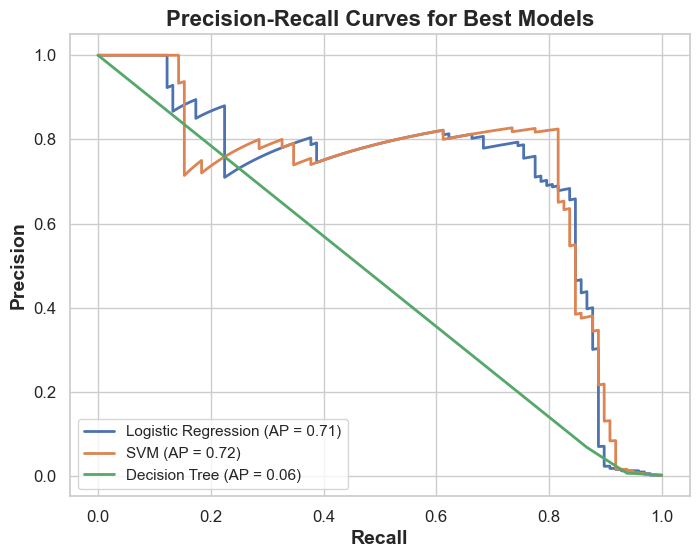

In [14]:
# Precission-Recall curve

# Logistic Regression
log_reg_scores = log_reg_grid.decision_function(X_test)
log_reg_precision, log_reg_recall, _ = precision_recall_curve(y_test, log_reg_scores)
log_reg_ap = average_precision_score(y_test, log_reg_scores)

# SVM
svm_scores = svm_grid.decision_function(X_test)
svm_precision, svm_recall, _ = precision_recall_curve(y_test, svm_scores)
svm_ap = average_precision_score(y_test, svm_scores)

# Decision Tree
tree_scores = tree_grid.predict_proba(X_test)[:, 1]
tree_precision, tree_recall, _ = precision_recall_curve(y_test, tree_scores)
tree_ap = average_precision_score(y_test, tree_scores)

# Plotting Precision-Recall curves
plt.figure(figsize=(8, 6))
plt.plot(log_reg_recall, log_reg_precision, label=f"Logistic Regression (AP = {log_reg_ap:.2f})", linewidth=2)
plt.plot(svm_recall, svm_precision, label=f"SVM (AP = {svm_ap:.2f})", linewidth=2)
plt.plot(tree_recall, tree_precision, label=f"Decision Tree (AP = {tree_ap:.2f})", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Best Models")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# Conclusion

The results indicate that both the logistic regression and SVM models achieve comparable performance, with SVM slightly edging out logistic regression in test set average precision. Importantly, both models deliver a high recall rate, capturing a significant portion of fraudulent cases, a crucial outcome in fraud detection where missing a true positive can be especially costly. Although precision for the fraudulent class remains low due to class imbalance, this trade-off is acceptable given the priority of identifying as many potential fraud cases as possible. With further enhancements such as advanced sampling techniques or ensemble methods to improve precision, these models provide a promising foundation for effective and reliable fraud detection.